In [ ]:
!pip install -q tensorflow-text
!pip install -q tf-models-official

import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

     |████████████████████████████████| 3.4MB 5.5MB/s 
     |████████████████████████████████| 1.1MB 5.7MB/s 
     |████████████████████████████████| 645kB 25.6MB/s 
     |████████████████████████████████| 706kB 29.7MB/s 
     |████████████████████████████████| 37.6MB 79kB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 1.2MB 37.2MB/s 
     |████████████████████████████████| 358kB 25.6MB/s 
     |████████████████████████████████| 102kB 10.4MB/s 
     |████████████████████████████████| 174kB 38.4MB/s 


Above Cell - install necessary packages.

---


Next, Download and load the training Stance Detection Dataset

In [ ]:
!wget "https://drive.google.com/uc?export=download&id=1r-0bA2HJRknNvaXbUZB4OsIXMyfi95IM" -O "stance_detection.zip"
!unzip stance_detection.zip

--2021-03-01 13:36:37--  https://drive.google.com/uc?export=download&id=1r-0bA2HJRknNvaXbUZB4OsIXMyfi95IM
Resolving drive.google.com (drive.google.com)... 64.233.189.100, 64.233.189.138, 64.233.189.102, ...
Connecting to drive.google.com (drive.google.com)|64.233.189.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-5k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/45rdaq0au8aad875b300dbonjlvnn2b6/1614605775000/12977678939721636440/*/1r-0bA2HJRknNvaXbUZB4OsIXMyfi95IM?e=download [following]
--2021-03-01 13:36:38--  https://doc-0s-5k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/45rdaq0au8aad875b300dbonjlvnn2b6/1614605775000/12977678939721636440/*/1r-0bA2HJRknNvaXbUZB4OsIXMyfi95IM?e=download
Resolving doc-0s-5k-docs.googleusercontent.com (doc-0s-5k-docs.googleusercontent.com)... 64.233.189.132, 2404:6800:4008:c07::84
Connecting to doc-0s-5k-docs.googleusercontent.com (doc-0s

In [ ]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

AUTOTUNE = tf.data.AUTOTUNE
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'stance_detection/train',
    batch_size=2,
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'stance_detection/test',
    batch_size=2)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 145 files belonging to 3 classes.
Found 33 files belonging to 3 classes.


Print Examples from Dataset

In [ ]:
for text_batch, label_batch in train_ds.take(5):
  for i in range(2):
    print(f'Tweet-fact pair: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Tweet-fact pair: b'For many women and girls, being home does not mean being safe. The COVID-19 lockdowns have brought a rise in domestic violence around the world. Speak out against gender-based violence now and join the Spotlight Initiative!  #withher https://t.co/iwbeXomcxD | Here are a list of resources for victims and survivors:\n Anti-Violence Project offers a 24-hour English/Spanish hotline for L.G.B.T.Q.+ experiencing abuse or hate-based violence: call 212-714-1141\nThe National Domestic Violence Hotline is available around the clock and in more than 200 languages: call 1-800-799-SAFE or chat with their advocates here or text LOVEIS to 22522.\n New York State Domestic and Sexual Violence Hotline is available in multiple languages: call 1-800-942-6906 for English. For deaf or hard of hearing: 711\nFor immediate dangers, call 911.'
Label : 0 (agree)
Tweet-fact pair: b'Novel Coronavirus spread can be stopped.\nCover your mouth properly while coughing  Avoid touching your eyes, nose

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'electra_small'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/google/electra_small/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['this is a tweet']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  2023  2003  1037  1056 28394  2102   102     0     0     0     0]
Input Mask : [1 1 1 1 1 1 1 1 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.3)(net)
  net = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(net)
  "net = tf.keras.layers.Dense(3, activation='softmax', name='classifier2')(net)"
  return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(bert_raw_result)

tf.Tensor([[0.7187892  0.0982247  0.18298608]], shape=(1, 3), dtype=float32)


In [ ]:
tf.keras.utils.plot_model(classifier_model)
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'encoder_outputs':  13548801    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
______________________________________________________________________________________________

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.SparseCategoricalAccuracy()

In [ ]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

Run Code to start Training

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds, epochs=epochs)

Training model with https://tfhub.dev/google/electra_small/2
Epoch 1/10
73/73 [==============================] - 26s 83ms/step - loss: 0.9872 - sparse_categorical_accuracy: 0.5523
Epoch 2/10
73/73 [==============================] - 6s 82ms/step - loss: 1.0403 - sparse_categorical_accuracy: 0.5974
Epoch 3/10
73/73 [==============================] - 6s 81ms/step - loss: 0.9061 - sparse_categorical_accuracy: 0.6543
Epoch 4/10
73/73 [==============================] - 6s 82ms/step - loss: 0.9008 - sparse_categorical_accuracy: 0.6892
Epoch 5/10
73/73 [==============================] - 6s 81ms/step - loss: 0.8021 - sparse_categorical_accuracy: 0.7150
Epoch 6/10
73/73 [==============================] - 6s 81ms/step - loss: 0.6075 - sparse_categorical_accuracy: 0.8024
Epoch 7/10
73/73 [==============================] - 6s 82ms/step - loss: 0.5381 - sparse_categorical_accuracy: 0.7980
Epoch 8/10
73/73 [==============================] - 6s 81ms/step - loss: 0.3921 - sparse_categorical_accuracy: 0

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

17/17 [==============================] - 1s 25ms/step - loss: 1.6382 - sparse_categorical_accuracy: 0.6364
Loss: 1.638159990310669
Accuracy: 0.6363636255264282


dict_keys(['loss', 'sparse_categorical_accuracy'])


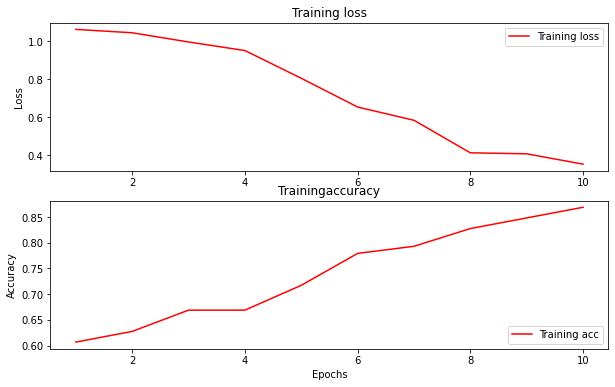

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.title('Trainingaccuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'stance_detection'
saved_model_path = './{}_'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

Run below code to download inference dataset and run the model on it.

In [ ]:
!wget "https://drive.google.com/uc?export=download&id=1pxaxus-AjI48yQugUCziHiqnR7cdsorL" -O "science_report_dataset.zip"
!unzip science_report_dataset.zip

--2021-03-01 13:39:08--  https://drive.google.com/uc?export=download&id=1pxaxus-AjI48yQugUCziHiqnR7cdsorL
Resolving drive.google.com (drive.google.com)... 64.233.189.113, 64.233.189.139, 64.233.189.101, ...
Connecting to drive.google.com (drive.google.com)|64.233.189.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-5k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/scsurs594f43cct8h1fnp96nraf84rt0/1614605925000/12977678939721636440/*/1pxaxus-AjI48yQugUCziHiqnR7cdsorL?e=download [following]
--2021-03-01 13:39:38--  https://doc-0k-5k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/scsurs594f43cct8h1fnp96nraf84rt0/1614605925000/12977678939721636440/*/1pxaxus-AjI48yQugUCziHiqnR7cdsorL?e=download
Resolving doc-0k-5k-docs.googleusercontent.com (doc-0k-5k-docs.googleusercontent.com)... 64.233.189.132, 2404:6800:4008:c07::84
Connecting to doc-0k-5k-docs.googleusercontent.com (doc-0k

In [ ]:
import pandas as pd

def print_my_examples(inputs, results):
  for i in range(len(inputs)):
      print("input: {}: \npredict class: {}".format(inputs[i], results[i]))
  print()


df = pd.read_csv('./processed/2020-03-24_to_2020-04-01_ennonrt_3_stnc_dtctn.csv')
df.head()
df = df[['TweetText', 'Fact']]
examples = []
for idx, row in df.iterrows():
    txt = ' | '.join([row['TweetText'], row['Fact']])
    examples.append(txt)
examples = examples[0:10]
reloaded_results = tf.argmax(reloaded_model(tf.constant(examples)), 1)

print('Results from the model in memory:')
print_my_examples(examples, reloaded_results)

Results from the model in memory:
input: Do you know a child or young person who may be feeling anxious about COVID-19? Resources are now available on our website to support your conversations on what they need to know about the virus. Visit https://t.co/QO4J2cF86d https://t.co/AipD3cDLjj | If you are feeling ill with COVID-19 symptoms (such as fever, cough, difficulty breathing, muscle pain or general weakness), it is recommended that you contact your local healthcare services online or by telephone. If your healthcare provider believes there is a need for a laboratory test for the virus that causes COVID-19, he/she will inform you of the procedure to follow and advise where and how the test can be performed.: 
predict class: 2
input: #diamonds #jewelry Stock Losses Worsen as Oil Drops, Dow Down 900 Points: Stocks slashed their earlier gains on Friday as investors concluded a week of wild swings. Wall Street has been grappling with fears over the coronavirus’ https://t.co/3F5KDlcHEs h

In [ ]:
import glob

final_results = []
paths = glob.glob('./processed/*')

for p in paths:
    df = pd.read_csv(p)
    df = df[['TweetText', 'Fact']]
    examples = []
    for idx, row in df.iterrows():
        txt = ' | '.join([row['TweetText'], row['Fact']])
        examples.append(txt)

    reloaded_results = tf.argmax(reloaded_model(tf.constant(examples)), 1)
    print(reloaded_results)
    break

tf.Tensor(
[0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 2 0 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 2 2 0 0 0
 2 2 2 2 0 2 2 0 2 2 0 0 0 2 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 2 0 0 0
 0 2 0 0 0 0 2 0 0 2 0 2 0 2 2 2 2 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0
 0 0 2 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 2
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 2 0 2 2 0 0 2 2
 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 0 2 0 0 0 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 2 0 0 0 2 2 2 0 2 2 0 0 2 0 2 2 0 0 2 0 0 0 2 2 0 0 0 0 0 0 0 0 2
 0 0 2 0 0 0 2 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 2 0
 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 2 2 2 2 2 2 0 2 0 0 0 0 0 0 0 0 2 0 2 2 2
 0 2 0 0 2 2 0 0 2 2 0 0 0 2 2 0 0 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 2 0 2 0 2 0

To print stance disagree examples

In [ ]:
import numpy as np
disagrees = np.array(examples)[reloaded_results.numpy() == 1]
print(disagrees)

[]


To print stance agree examples

In [ ]:
agrees = np.array(examples)[reloaded_results.numpy() == 0]
print(agrees)

['An antiviral spray against novel #coronavirus has developed in Shanghai Public Health Clinical Center, which can be put into throat as shield from virus. The spray can greatly help protect front-line medical staff, yet mass-production for public  https://t.co/TccL6IFP71 | Hydrogen peroxide-based systems\xa0for cleaning, disinfecting, and storing contact lenses should be effective against the virus that causes COVID-19.For other disinfection methods, such as multipurpose solution and ultrasonic cleaners, there is currently not enough scientific evidence to determine efficacy against the virus.Always use solution\xa0to disinfect your contact lenses and case to kill germs that may be present.Handle your lenses over a surface that has been cleaned and disinfected.Find more information about\xa0how coronavirus spreads\xa0and\xa0how to protect yourself.Visit\xa0CDC’s contact lens website\xa0for more information on healthy contact lens wear and care.'
 'An antiviral spray against novel #cor

To print stance neutral examples

In [ ]:
neutrals = np.array(examples)[reloaded_results.numpy() == 2]
print(neutrals)

['Facilities to go to?  If the coronavirus bacteria 🦠 gets in the hospitals how the hell you prevent other vulnerable patients from catching the flu? Ventilation systems will carry the virus? We already get hospital grade bacteria 🦠 once in and staph wtf is the plan B*** |  The virus that causes COVID-19 is spreading from person-to-person. Someone who is actively sick with COVID-19 can spread the illness to others. That is why CDC recommends that these patients be isolated either in the hospital or at home (depending on how sick they are) until they are better and no longer pose a risk of infecting others. How long someone is actively sick can vary so the decision on when to release someone from isolation is made on a case-by-case basis in consultation with doctors, infection prevention and control experts, and public health officials and involves considering specifics of each situation including disease severity, illness signs and symptoms, and results of laboratory testing for that p